In [5]:
import ROOT
import numpy as np

In [6]:
def linspace(start, end, steps):
    values = []
    for i in range(steps):
        values.append(start + i*(end-start)/(steps-1))
    return values

Warning in <TCanvas::Constructor>: Deleting canvas with same name: I dont even know where this will show up


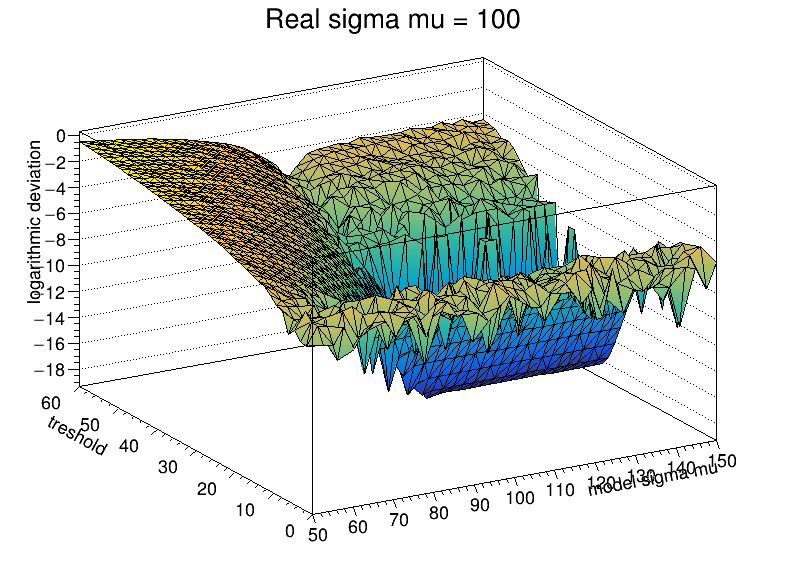

In [10]:
real_signal_mu = 100
real_signal_sigma = 20

model_signal_mu_spread_interval_length = 50 * 2
model_signal_mu_step_count = 40

model_signal_mus = linspace(real_signal_mu-model_signal_mu_spread_interval_length/2, real_signal_mu + model_signal_mu_spread_interval_length/2, model_signal_mu_step_count)
model_signal_sigma = real_signal_sigma

treshold_lower = 0
treshold_upper = 60
treshold_step_count = 40
treshold_values =  linspace(treshold_lower, treshold_upper, treshold_step_count)

noise_mu = 0
noise_sigma = 5

#print(model_signal_mus)
#print(treshold_values)

model_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (noise_mu, noise_sigma), -100, 500)
model_noise.SetNpx(10000)


"""
# more paramaters
simulation_time = 1 #seconds
bunch_crossings_per_second = 40 * 1e6
collisions_per_bunch_crossing = en fördelning
particles_per_collision = en fördelning
particles_reaching_the_sensor = en fördelning vi inte känner till och inte är vår uppgift att känna till
 
"""

#plot_signal_mus = np.array([], dtype=np.double)
#plot_tresholds = np.array([], dtype=np.double)
#plot_estimation_ratio = np.array([], dtype=np.double)

prng = ROOT.TRandom3(123)

some_plot = ROOT.TGraph2D()

point_index = 0

for model_signal_mu in model_signal_mus:
    model_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (model_signal_mu, model_signal_sigma), -100, 500)
    model_signal.SetNpx(10000)
    for treshold_value in treshold_values:
        model_expected_signal_above = 1 - model_signal.Integral(-100, treshold_value)/model_signal.Integral(-100, 500)
        model_expected_noise_above = 1 - model_noise.Integral(-100, treshold_value)/model_noise.Integral(-100, 500)
        #print(model_expected_signal_above)
        #print(model_expected_noise_above)
        
        event_count = 10000
        event_ratio = 0.5
        signal_count = int(round(event_count * event_ratio))
        noise_count = event_count - signal_count

        noise_above_count = 0
        signal_above_count = 0

        for i in range(signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(noise_count):
            noise = prng.Gaus(noise_mu, noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        """
        Antag att vi vet:
            total_above_count
            event_ratio
            model_expected_signal_above
            model_expected_noise_above
        
        Hur ska vi räkna?
        Vi vill beräkna ett värde som är så nära signal_count som möjligt.
        """
        
        total_count = total_above_count/(event_ratio*model_expected_signal_above + (1-event_ratio)*model_expected_noise_above)
        computed_signal_count = total_count*event_ratio
        # Compare with signal_count which is the correct value
        #print([model_signal_mu, treshold_value])
        deviation = np.log(0.00000001 + abs(1 - computed_signal_count/signal_count))
        #deviation = computed_signal_count/signal_count
        #print(deviation)
        
        
        # Hur vill vi spara ner det här då?
        # Vi vill göra en snygg plott på något sätt.
        # plot_signal_mus.append(model_signal_mu)
        # plot_tresholds.append(treshold_value)
        # plot_estimation_ratio.append(estimation_ratio)
        # np.append(plot_signal_mus, model_signal_mu)
        # np.append(plot_tresholds, treshold_value)
        # np.append(plot_estimation_ratio, estimation_ratio)
        some_plot.SetPoint(point_index, model_signal_mu, treshold_value, deviation)
        point_index += 1
        
canvas = ROOT.TCanvas("I dont even know where this will show up", "not this either", 800, 600)
some_plot.Draw("TRI1")
some_plot.SetTitle("Real sigma mu = "+ str(real_signal_mu) + "; model sigma mu; treshold; logarithmic deviation");
canvas.Draw()
